# Spectral Analysis for paper

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from tqdm import tqdm
import swordfish as sf
from WIMpy import DMUtils as DMU
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz

from scipy.integrate import cumtrapz

rc('text', usetex=True)
rc('font',**{'family':'sans-serif','sans-serif':['cmr']})
rc('font',**{'family':'serif','serif':['cmr']})
%matplotlib inline

#### Load information for Sylvanite

In [20]:
nuclei_Syl = ["Au", "Ag", "Te"]
Syl_abun = np.array([0.343,0.0627,0.5936])
Syl_p = np.array([79,47,52])
Syl_n = np.array([118,61,76])

E_Au, dEedx_Au, dEdx_data_Au = np.loadtxt("../Data/dRdESRIM/Au-Syl-CC1.txt", usecols=(0,1,2), unpack=True)
E_Ag, dEedx_Ag, dEdx_data_Ag = np.loadtxt("../Data/dRdESRIM/Ag-Syl-CC1.txt", usecols=(0,1,2), unpack=True)
E_Te, dEedx_Te, dEdx_data_Te = np.loadtxt("../Data/dRdESRIM/Te-Syl-CC1.txt", usecols=(0,1,2), unpack=True)

dEdx_data_Au += dEedx_Au
dEdx_data_Ag += dEedx_Ag
dEdx_data_Te += dEedx_Te

dEdx_data_Au *= 1.e-3 # Convert keV/micro_m to keV/nm
dEdx_data_Ag *= 1.e-3 # Convert keV/micro_m to keV/nm
dEdx_data_Te *= 1.e-3 # Convert keV/micro_m to keV/nm

x_Au = cumtrapz(1/dEdx_data_Au,x=E_Au, initial=0)
x_Ag = cumtrapz(1/dEdx_data_Ag,x=E_Ag, initial=0)
x_Te = cumtrapz(1/dEdx_data_Te,x=E_Te, initial=0)

Etox_Au = interp1d(E_Au, x_Au, fill_value='extrapolate')
Etox_Ag = interp1d(E_Ag, x_Ag, fill_value='extrapolate')
Etox_Te = interp1d(E_Te, x_Te, fill_value='extrapolate')

dEdx_Au = interp1d(x_Au, dEdx_data_Au, fill_value='extrapolate')
dEdx_Ag = interp1d(x_Ag, dEdx_data_Ag, fill_value='extrapolate')
dEdx_Te = interp1d(x_Te, dEdx_data_Te, fill_value='extrapolate')

xtoE_Au = interp1d(x_Au, E_Au, fill_value='extrapolate')
xtoE_Ag = interp1d(x_Ag, E_Ag, fill_value='extrapolate')
xtoE_Te = interp1d(x_Te, E_Te, fill_value='extrapolate')

dEdx_Syl = [dEdx_Au,dEdx_Ag,dEdx_Te]
Etox_Syl = [Etox_Au,Etox_Ag,Etox_Te]
xtoE_Syl = [xtoE_Au,xtoE_Ag,xtoE_Te]

dEdx_nuclei_Syl = dict(zip(nuclei_Syl, dEdx_Syl))
Etox_nuclei_Syl = dict(zip(nuclei_Syl, Etox_Syl))
xtoE_nuclei_Syl = dict(zip(nuclei_Syl, xtoE_Syl))
ratio_nuclei_Syl = dict(zip(nuclei_Syl, Syl_abun))

#### Load information for Zabuyelite

In [25]:
nuclei_Zab = ["Li", "C", "O"]
Zab_abun = np.array([0.189,0.162,0.649])
Zab_p = np.array([3,6,8])
Zab_n = np.array([4,6,8])

#NB: The interpolation function had the same name as "dEdx_Li" as the data you were loading in
#I've renamed the arrays to dEdx_data_Li (etc.), to clear this up...
#2338
E_Li, dEedx_Li, dEdx_data_Li = np.loadtxt("../Data/dRdESRIM/Li-Zab-CC2338.txt", usecols=(0,1,2), unpack=True)
E_C, dEedx_C, dEdx_data_C = np.loadtxt("../Data/dRdESRIM/C-Zab-CC2338.txt", usecols=(0,1,2), unpack=True)
E_O, dEedx_O, dEdx_data_O = np.loadtxt("../Data/dRdESRIM/O-Zab-CC2338.txt", usecols=(0,1,2), unpack=True)

# Add electronic stopping to nuclear stopping
dEdx_data_Li += dEedx_Li 
dEdx_data_C += dEedx_C 
dEdx_data_O += dEedx_O 

dEdx_data_Li *= 1.e-3 # Convert keV/micro_m to keV/nm
dEdx_data_C *= 1.e-3 # Convert keV/micro_m to keV/nm
dEdx_data_O *= 1.e-3 # Convert keV/micro_m to keV/nm

x_Li = cumtrapz(1/dEdx_data_Li,x=E_Li, initial=0)
x_C = cumtrapz(1/dEdx_data_C,x=E_C, initial=0)
x_O = cumtrapz(1/dEdx_data_O,x=E_O, initial=0)

Etox_Li = interp1d(E_Li, x_Li, bounds_error=False, fill_value='extrapolate')
Etox_C = interp1d(E_C, x_C, bounds_error=False, fill_value='extrapolate')
Etox_O = interp1d(E_O, x_O, bounds_error=False, fill_value='extrapolate')

xtoE_Li = interp1d(x_Li, E_Li, bounds_error=False, fill_value='extrapolate')
xtoE_C = interp1d(x_C, E_C, bounds_error=False, fill_value='extrapolate')
xtoE_O = interp1d(x_O, E_O, bounds_error=False, fill_value='extrapolate')

dEdx_Li = interp1d(x_Li, dEdx_data_Li, bounds_error=False, fill_value='extrapolate')
dEdx_C = interp1d(x_C, dEdx_data_C, bounds_error=False, fill_value='extrapolate')
dEdx_O = interp1d(x_O, dEdx_data_O, bounds_error=False, fill_value='extrapolate')

dEdxZab = [dEdx_Li,dEdx_C,dEdx_O]
EtoxZab = [Etox_Li,Etox_C,Etox_O]
xtoE_Zab = [xtoE_Li,xtoE_C,xtoE_O]

dEdx_nuclei_Zab = dict(zip(nuclei_Zab, dEdxZab))
Etox_nuclei_Zab = dict(zip(nuclei_Zab, EtoxZab))
ratio_nuclei_Zab = dict(zip(nuclei_Zab, Zab_abun))
xtoE_nuclei_Zab = dict(zip(nuclei_Zab, xtoE_Zab))

In [50]:
def dRdx(x, sigma, m, rock='Zab'):
    "Returns in events/nm/kg/Myr"
    if rock == 'Zab':
        nuclei = nuclei_Zab
        abun = Zab_abun
        xtoE_nuclei = xtoE_nuclei_Zab
        p = Zab_p
        n = Zab_n
        ratio_nuclei = ratio_nuclei_Zab
        dEdx_nuclei = dEdx_nuclei_Zab
        
    elif rock == 'Syl':
        nuclei = nuclei_Syl
        abun = Syl_abun
        xtoE_nuclei = xtoE_nuclei_Syl 
        p = Syl_p
        n = Syl_n
        ratio_nuclei = ratio_nuclei_Syl
        dEdx_nuclei = dEdx_nuclei_Syl
        
    dRdx = np.zeros_like(x)
    for i, nuc in enumerate(nuclei):
        Etemp = xtoE_nuclei[nuc](x)
        dRdx_nuc = (DMU.dRdE_standard(Etemp, p[i], n[i], m, sigma)
                                                    *dEdx_nuclei[nuc](x))
        dRdx += ratio_nuclei[nuc]*dRdx_nuc
    return dRdx*1e6*365

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


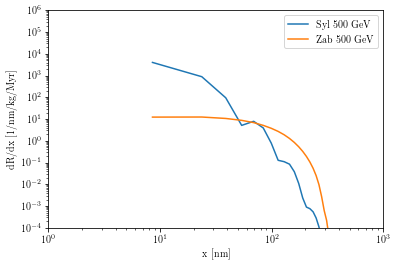

In [146]:
x_bins = np.linspace(1,1000,67)
x_width = np.diff(x_bins)
x_c = x_bins[:-1] + x_width/2
E_list = np.logspace(-1, 3, 500) # keV

Syl = dRdx(x_c, 1e-45, 500, rock='Syl')
Zab = dRdx(x_c, 1e-45, 500, rock='Zab')
plt.loglog(x_c, Syl, label='Syl 500 GeV')
plt.loglog(x_c, Zab, label='Zab 500 GeV')
plt.legend()
plt.ylabel("dR/dx [1/nm/kg/Myr]")
plt.xlabel("x [nm]")
plt.ylim(1e-4,1e6)
plt.xlim(1,1000)
plt.show()

#### Now we need to load the backgrounds

In [154]:
nu_list = ['DSNB', 'atm', 'hep', '8B', '15O', '17F', '13N', 'pep']
from scipy.ndimage.filters import gaussian_filter1d

def dRdx_nu(x, E, rock='Zab', components=False, gaussian=False):
    "Returns in events/nm/kg/Myr"
    nu_list = ['DSNB', 'atm', 'hep', '8B', '15O', '17F', '13N', 'pep']
    if rock == 'Zab':
        nuclei = nuclei_Zab
        abun = Zab_abun
        Etox_nuclei = Etox_nuclei_Zab
        p = Zab_p
        n = Zab_n
        ratio_nuclei = ratio_nuclei_Zab
        dEdx_nuclei = dEdx_nuclei_Zab
        
    elif rock == 'Syl':
        nuclei = nuclei_Syl
        abun = Syl_abun
        Etox_nuclei = Etox_nuclei_Syl 
        p = Syl_p
        n = Syl_n
        ratio_nuclei = ratio_nuclei_Syl
        dEdx_nuclei = dEdx_nuclei_Syl
    
    if components:
        dRdx = []
#         dRdx = np.zeros([len(nu_list),len(x)])
        dRdx_temp = np.zeros_like(x)
        for j, nu_source in enumerate(nu_list):
            for i, nuc in enumerate(nuclei):
                xtemp = Etox_nuclei[nuc](E)
                dRdx_nuc = (np.vectorize(DMU.dRdE_CEvNS)(E, p[i], n[i], flux_name=nu_source)
                                                            *dEdx_nuclei[nuc](xtemp))
                temp_interp = interp1d(xtemp, dRdx_nuc, fill_value='extrapolate')
                dRdx_temp += ratio_nuclei[nuc]*temp_interp(x)
#             dRdx[j,:] += dRdx_temp*1e6*365
            if gaussian:
                dRdx.append(gaussian_filter1d(dRdx_temp*1e6*365,1)+1e-20)
            else:
                dRdx.append(dRdx_temp*1e6*365)+1e-20
    else:
        dRdx = np.zeros_like(x)
        for i, nuc in enumerate(nuclei):
            xtemp = Etox_nuclei[nuc](E)
            dRdx_nuc = (np.vectorize(DMU.dRdE_CEvNS)(E, p[i], n[i], flux_name='all')
                                                        *dEdx_nuclei[nuc](xtemp))
            temp_interp = interp1d(xtemp, dRdx_nuc, fill_value='extrapolate')
            dRdx += ratio_nuclei[nuc]*temp_interp(x)*1e6*365
        if gaussian:
            dRdx = gaussian_filter1d(dRdx*1e6*365,1)+1e-20
    return dRdx

dRdx_Sylnu = dRdx_nu(x_c, E_list, rock='Syl', components=True, gaussian=True)
dRdx_Zabnu = dRdx_nu(x_c, E_list, rock='Zab', components=True, gaussian=True)

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


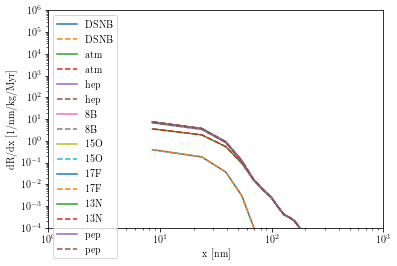

In [157]:
for i, nusource in enumerate(nu_list):
    plt.loglog(x_c,dRdx_Sylnu[i], label=nusource)
    plt.loglog(x_c,dRdx_Sylnu_gauss[i], label=nusource, ls='--')

# plt.loglog(x_c,dRdx_Sylnu[0], 'C0', label='test')
# plt.loglog(x_c,dRdx_Sylnu_gauss[0], 'C0', label='test', ls='--')
    
# plt.loglog(x_c, dRdx_Sylnu_all, label='Total')
plt.legend()
plt.ylabel("dR/dx [1/nm/kg/Myr]")
plt.xlabel("x [nm]")
plt.ylim(1e-4,1e6)
plt.xlim(1,1000)
plt.show()

In [165]:
ref_sig = 1e-47
systematics = [0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]
mlist = np.logspace(-0.5,4,num=100)
Syl_limit = np.zeros_like(mlist)
Syl_DR = np.zeros_like(mlist)

for i, m in enumerate(mlist):
    SF = sf.Swordfish(dRdx_Sylnu, T=systematics, E=np.ones_like(dRdx_Sylnu[0])*100)
    sig = gaussian_filter1d(dRdx(x_c, ref_sig, m, rock='Syl'),1)+1e-20
    UL = SF.upperlimit(sig, 0.05)
    DR = SF.discoveryreach(sig, 2.87e-7)
    Syl_limit[i] = ref_sig * UL
    Syl_DR[i] = ref_sig * DR

In [166]:
ref_sig = 1e-47
systematics = [0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]
Zab_limit = np.zeros_like(mlist)
Zab_DR = np.zeros_like(mlist)

for i, m in enumerate(mlist):
    SF = sf.Swordfish(dRdx_Zabnu, T=systematics, E=np.ones_like(dRdx_Zabnu[0])*100)
    sig = gaussian_filter1d(dRdx(x_c, ref_sig, m, rock='Zab'),1)+1e-20
    UL = SF.upperlimit(sig, 0.05)
    DR = SF.discoveryreach(sig, 2.87e-7)
    Zab_limit[i] = ref_sig * UL
    Zab_DR[i] = ref_sig * DR

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


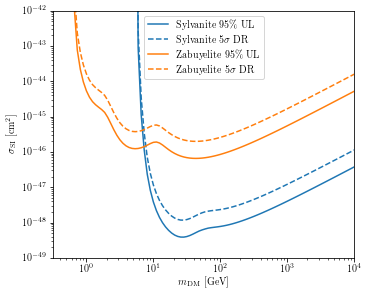

In [168]:
plt.figure(figsize=(5,4))
plt.loglog(mlist,Syl_limit, color='C0', linestyle='-', label=r'Sylvanite 95\% UL')
plt.loglog(mlist,Syl_DR, color='C0', linestyle='--', label=r'Sylvanite $5\sigma$ DR')
plt.loglog(mlist,Zab_limit, color='C1', linestyle='-', label=r'Zabuyelite 95\% UL')
plt.loglog(mlist,Zab_DR, color='C1', linestyle='--', label=r'Zabuyelite $5\sigma$ DR')
plt.ylabel(r'$\sigma_{\mathrm{SI}} ~[\mathrm{cm}^2]$')
plt.xlabel(r'$m_{\mathrm{DM}} ~[\mathrm{GeV}]$')
plt.xlim(10**(-0.5),1e4)
plt.ylim(1e-49,1e-42)
plt.legend()
plt.tight_layout(pad=0.3)
# plt.show()
plt.savefig("../plots/limits_nubkg_separate.pdf")